<a href="https://colab.research.google.com/github/vedrajiit/GoogleCollab/blob/main/DuplicateDetection_InExcelFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [ ]:
# !pip install sentence_transformers
# import pandas as pd
# import time
# from sentence_transformers import SentenceTransformer
# from sklearn.metrics.pairwise import cosine_similarity
# from joblib import Parallel, delayed
# import numpy as np
# import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Total words: 15354
Time taken to process: 22.35362935066223 seconds
Duplicates removed. Cleaned data saved to: /content/drive/MyDrive/Cleaned_Address_Data_BERT_Optimized.xlsx


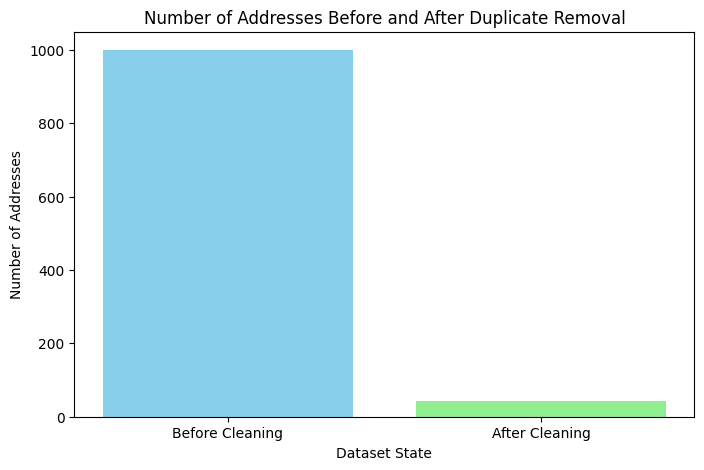

In [ ]:
# # Duplicate detection using a single column --- 1st problem
# # Load dataset
# start_time = time.time()
# threshold = 0.98 # Adjust the threshold as needed
# filepath = r'/content/drive/MyDrive/Synthetic_Address_Data.xlsx'
# df = pd.read_excel(filepath, sheet_name='Master')

# # Preprocess the addresses
# def combining_all_texts(column=None):
#     list_of_addresses = df[column].fillna("").tolist()  # Handle missing values
#     total_words = sum(len(sentence.split()) for sentence in list_of_addresses)
#     print(f"Total words: {total_words}")
#     return list_of_addresses

# # Load the pre-trained BERT model
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # Batched embedding function
# def batched_embeddings(address_list, batch_size=128):
#     embeddings = []
#     for i in range(0, len(address_list), batch_size):
#         batch = address_list[i:i + batch_size]
#         batch_embeddings = model.encode(batch, convert_to_tensor=False)
#         embeddings.extend(batch_embeddings)
#     return np.array(embeddings)

# # Convert addresses to embeddings using BERT in batches
# list_of_address = combining_all_texts('Complete Address')
# embeddings = batched_embeddings(list_of_address)

# # Calculate pairwise similarity in parallel
# def find_similar_pairs(i, row_embedding, embeddings, threshold):
#     similar_pairs = []
#     similarities = cosine_similarity([row_embedding], embeddings[i + 1:])[0]  # Only compare with subsequent rows
#     for j, score in enumerate(similarities):
#         if score > threshold:
#             similar_pairs.append((i, i + 1 + j, score))
#     return similar_pairs

# # Collect duplicates in parallel
# similar_pairs = Parallel(n_jobs=-1)(delayed(find_similar_pairs)(i, embeddings[i], embeddings, threshold)
#                                     for i in range(len(embeddings) - 1))

# # Flatten list of similar pairs and keep the first occurrence of each group
# rows_to_delete = set()
# for pairs in similar_pairs:
#     for (i, j, score) in pairs:
#         rows_to_delete.add(j)  # Keep the first row and delete subsequent similar ones

# # Remove duplicate rows
# df_cleaned = df.drop(rows_to_delete)

# # Save the cleaned DataFrame to a new Excel file
# output_filepath = r'/content/drive/MyDrive/Cleaned_Address_Data_BERT_Optimized.xlsx'
# df_cleaned.to_excel(output_filepath, index=False)

# # Log time taken
# end_time = time.time()
# print(f'Time taken to process: {end_time - start_time} seconds')
# print(f'Duplicates removed. Cleaned data saved to: {output_filepath}')

# # Get the number of addresses before and after cleaning
# num_addresses_before = len(df) # Get the number of addresses before cleaning
# num_addresses_after = len(df_cleaned) # Get the number of addresses after cleaning

# # Plot the number of addresses before and after cleaning
# plt.figure(figsize=(8, 5))
# plt.bar(['Before Cleaning', 'After Cleaning'], [num_addresses_before, num_addresses_after], color=['skyblue', 'lightgreen'])
# plt.title('Number of Addresses Before and After Duplicate Removal')
# plt.xlabel('Dataset State')
# plt.ylabel('Number of Addresses')
# plt.show()

Code for Full Row Comparison: 2nd problem



Adding a column position marker multiplier can help differentiate values based on their positions. By assigning a unique multiplier to each column, we effectively give each value a unique weight based on its position. Here’s how you can do it in your code:

Steps to Implement Column Position Marker Multiplier

In [ ]:
!pip install sentence_transformers
import pandas as pd
import numpy as np
import time
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed

# Load dataset
start_time = time.time()
threshold = 0.95  # Adjust the threshold as needed
filepath = r'/content/drive/MyDrive/Validations/Testcase4.xlsx'
df = pd.read_excel(filepath, sheet_name='Master')

In [ ]:
# df.info() #total entries are 1000

In [ ]:
numeric_columns=df.select_dtypes(include=['number']).columns.tolist()
numeric_columns
text_columns=df.select_dtypes(include=['object']).columns.tolist()
# text_columns

In [ ]:
# Load the pre-trained BERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Batched embedding function for text columns
def batched_embeddings(address_list, batch_size=128):
    embeddings = []
    for i in range(0, len(address_list), batch_size):
        batch = address_list[i:i + batch_size]
        batch_embeddings = model.encode(batch, convert_to_tensor=False)
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

# Convert addresses to embeddings using BERT in batches
list_of_address = df[text_columns[0]].fillna("").tolist()  # Handle missing values
text_embeddings = batched_embeddings(list_of_address)

# Normalize numeric columns and apply exponential position-based multipliers
scaler = MinMaxScaler()
normalized_numeric_data = scaler.fit_transform(df[numeric_columns].fillna(0))

# Apply exponential multipliers: 2^i for each numeric column
for i in range(len(numeric_columns)):
    normalized_numeric_data[:, i] *= (2 ** i)

# Concatenate text embeddings and processed numeric data
combined_data = np.hstack((text_embeddings, normalized_numeric_data))

# Function to find duplicate pairs in parallel
def find_similar_pairs(i, row_embedding, embeddings, threshold):
    similar_pairs = []
    similarities = cosine_similarity([row_embedding], embeddings[i + 1:])[0]  # Only compare with subsequent rows
    for j, score in enumerate(similarities):
        if score > threshold:
            similar_pairs.append((i, i + 1 + j, score))
    return similar_pairs

# Collect duplicates in parallel
similar_pairs = Parallel(n_jobs=-1)(delayed(find_similar_pairs)(i, combined_data[i], combined_data, threshold)
                                    for i in range(len(combined_data) - 1))

# Flatten list of similar pairs and mark duplicates for deletion
rows_to_delete = set()
for pairs in similar_pairs:
    for (i, j, score) in pairs:
        rows_to_delete.add(j)  # Keep the first row and delete subsequent similar ones

# Remove duplicate rows
df_cleaned = df.drop(rows_to_delete)

# Save the cleaned DataFrame to a new Excel file
output_filepath = r'/content/drive/MyDrive/CleanedData/Cleaned_Address_Data_BERT_Optimized4.xlsx'
df_cleaned.to_excel(output_filepath, index=False)

# Log time taken
end_time = time.time()
print(f'Time taken to process: {end_time - start_time} seconds')
print(f'Duplicates removed. Cleaned data saved to: {output_filepath}')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Time taken to process: 21.35025119781494 seconds
Duplicates removed. Cleaned data saved to: /content/drive/MyDrive/CleanedData/Cleaned_Address_Data_BERT_Optimized4.xlsx


In [ ]:
'''
let check the duplicate for first  4 rows  using both pandas and our algo'''

#slice last two column of first two rows
df.iloc[:3,]

,Name,Address Line 1,Address Line 2,City,State,Country,Postal Code,Formatted Address
0,Mr. Rajesh Kumar,"56, Liberty Street, Bangalore",Near MG Road,Bangalore,Karnataka,India,560001.0,"56 Liberty Street Near MG Road, Bangalore Karn..."
1,Rajesh K. Kumar,"56, Liberty Street, Bengaluru",Near MG Road,Bengaluru,Karnataka,India,560001.0,"56 Liberty Street Near MG Road, Bengaluru Karn..."
2,Mrs. Priya Sharma,"33, Palm Grove, Cochin",Near Marine Drive,Cochin,Kerala,India,682001.0,"33 Palm Grove Near Marine Drive, Cochin Kerala..."


In [ ]:
df.iloc[:3,].duplicated()


,0
0,False
1,False
2,False


In [ ]:
import pandas as pd

# Load the Excel file
filepath = r'/content/drive/MyDrive/Synthetic_Address_Data.xlsx'  # Replace with your file path
df = pd.read_excel(filepath, sheet_name='Master')

# Detect duplicates in a specific column (e.g., 'Formatted Address')
duplicate_rows = df[df.duplicated(subset='Complete Address', keep=False)]

# Print the number of duplicate rows found
print(f"Number of duplicate rows detected: {len(duplicate_rows)}")

# Display the duplicate rows (optional)
print(duplicate_rows)

# Save duplicate rows to a new Excel file (optional)
output_filepath = r'/content/drive/MyDrive/Cleaned_Address_Data_BERT_Optimized.xlsx'  # Replace with your save path
duplicate_rows.to_excel(output_filepath, index=False)
print(f'Duplicate rows saved to: {output_filepath}')

# Log time taken
end_time = time.time()
print(f'Time taken to process: {end_time - start_time} seconds')
print(f'Duplicates removed. Cleaned data saved to: {output_filepath}')


Number of duplicate rows detected: 829
     First Name Middle Name Last Name       Flat No Floor Block  \
0      R. Ravee         NaN     Kumar           101   1st     A   
1    Mr. Kishan         NaN    Patil   House No. 22   NaN   NaN   
2          Ravi         NaN     Kumar           101     1     A   
3        Kishan         NaN       Ptl     H. No. 22   NaN   NaN   
4     Mr. Arjan       Reddy       Rao          A800   NaN   NaN   
..          ...         ...       ...           ...   ...   ...   
994   Mr. Arjan       Reddy       Rao          A800   NaN   NaN   
995   Dr. Arjun         NaN     Singh           NaN   NaN   NaN   
996      Dr. A.         NaN     Singh           NaN   NaN   NaN   
998   Mr. Arjun       Reddi       Rao          A800   NaN   NaN   
999    Dr. Rave         NaN     Kumar           101     1     A   

      Apartment Name        Society Name               Street  \
0                NaN  Sunshine Residency          Gandhi Park   
1                NaN      